In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_results

NUM_SAMPLES = 500
device = 'cpu:0'

# Force Float 64
tf.keras.backend.set_floatx('float64')


In [3]:
#Reação Não-elementar de duas etapas:
# A + B -> C
# B + C -> D

class Reactions(tf.keras.Model):
  
  def __init__(self, k1, k2, **kwargs):
    super().__init__(**kwargs)
    
    self.k1, self.k2 = k1, k2
  
  @tf.function
  def call(self, t, C):
    # C = [CA, CB, CC, CD]
    CA, CB, CC, CD = tf.unstack(C)
    
    r1 = k1 * CA * CB
    r2 = k2 * CB* CC
    
    dA_dt = -r1
    dB_dt = -r1 - r2
    dC_dt = r1 - r2
    dD_dt = r2
    
    return tf.stack([dA_dt, dB_dt, dC_dt, dD_dt])

In [4]:
t = tf.linspace(0., 5., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1, 0, 0], dtype=tf.float64)

k1 = 1
k2 = 1.5

In [5]:
with tf.device(device):
  result = odeint(Reactions(k1, k2), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (500, 4)


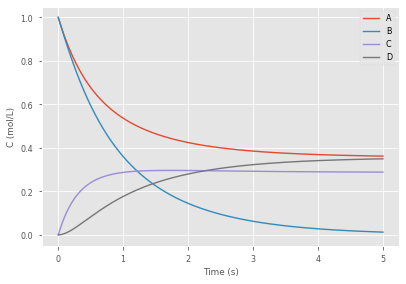

In [8]:
plot_results(t, result, labels=['A', 'B', 'C', 'D']);
plt.xlabel('Time (s)');
plt.ylabel('C (mol/L)');

In [6]:
class ReactionsTrainable(tf.keras.Model):
  
  def __init__(self, k1, k2, **kwargs):
    super().__init__(**kwargs)
    
    self.k1, self.k2 = k1, k2

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(4,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(4, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [A, B, C, D]
    A, B, C, D = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 4]))  # [1, 4] -> [1, 4]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    pred3 = n_out[0, 2]
    pred4 = n_out[0, 3]
    
    dA_dt = -self.k1*A*pred1        #pred1 = B
    dB_dt = -self.k1*A*B - pred2    #pred2 = self.k2*B*C
    dC_dt = pred3 - self.k2*B*C     #pred3 = self.k1*A*B
    dD_dt = self.k2*pred4           #pred4 = B*C
    
    
    return tf.stack([dA_dt, dB_dt, dC_dt, dD_dt])

In [7]:
t_train = tf.linspace(0., 3., num=30)  
initial_states_train = tf.convert_to_tensor([1, 1, 0, 0], dtype=tf.float64)

k1 = 1
k2 = 1.5

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [8]:
from tensorflow.keras import backend as K
K.clear_session()

In [9]:
start = time.time()
with tf.device(device):
  model = ReactionsTrainable(k1, k2)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(Reactions(k1, k2), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()
end = time.time()
time_elapsed = end-start
print("Time elapsed: %f s" % time_elapsed)

Computing ground truth...
Ground truth shape : (30, 4)
Epoch 1
Loss : 0.08876012485035485
LR : 0.0099309245

Epoch 2
Loss : 0.0771377966911099
LR : 0.009862327

Epoch 3
Loss : 0.0701484715504636
LR : 0.009794203

Epoch 4
Loss : 0.07037224655060068
LR : 0.0097265495

Epoch 5
Loss : 0.06505862629552932
LR : 0.009659363

Epoch 6
Loss : 0.06555145430652703
LR : 0.009592641

Epoch 7
Loss : 0.06481748446424887
LR : 0.009526379

Epoch 8
Loss : 0.0656050430305602
LR : 0.009460577

Epoch 9
Loss : 0.06635038581614308
LR : 0.009395227

Epoch 10
Loss : 0.06545490226131576
LR : 0.0093303295

Epoch 11
Loss : 0.0647282985237293
LR : 0.00926588

Epoch 12
Loss : 0.06447009561119975
LR : 0.009201876

Epoch 13
Loss : 0.06392878482368755
LR : 0.009138315

Epoch 14
Loss : 0.06353999740574999
LR : 0.009075192

Epoch 15
Loss : 0.06380691039261159
LR : 0.0090125045

Epoch 16
Loss : 0.06411922357094055
LR : 0.00895025

Epoch 17
Loss : 0.06394946207389134
LR : 0.008888427

Epoch 18
Loss : 0.06362300965294633
LR

In [10]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [11]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [12]:
start = time.time()
model = bfgs_optimizer.minimize(loss_wrapper, model)
end = time.time()
time_elapsed = end - start
print("Time Elapsed: %f" % time_elapsed)

Iter: 1 loss: 0.00361573591971806
Iter: 2 loss: 0.0036006963774657934
Iter: 3 loss: 0.0036789664762470723
Iter: 4 loss: 0.0035982836820079413
Iter: 5 loss: 0.0036109797981478424
Iter: 6 loss: 0.0035937302411955408
Iter: 7 loss: 0.0035911170541647517
Iter: 8 loss: 0.0035946412534266568
Iter: 9 loss: 0.0035897947994006757
Iter: 10 loss: 0.0035890284074380158
Iter: 11 loss: 0.0035859755320046347
Iter: 12 loss: 0.0035541600326983776
Iter: 13 loss: 0.0030107121043774334
Iter: 14 loss: 0.016149332495962381
Iter: 15 loss: 0.0027553683684050688
Iter: 16 loss: 0.0031440363301780392
Iter: 17 loss: 0.0023186760983220037
Iter: 18 loss: 0.0021577498566378414
Iter: 19 loss: 0.0021177343890287337
Iter: 20 loss: 0.0021158872344144127
Iter: 21 loss: 0.002103952607807753
Iter: 22 loss: 0.0020657049468291869
Iter: 23 loss: 0.013651310932993996
Iter: 24 loss: 0.0019598770294978795
Iter: 25 loss: 0.0019021300517878129
Iter: 26 loss: 0.0019001146101233952
Iter: 27 loss: 0.0018886686095001858
Iter: 28 loss: 

In [13]:
#Interpolating
t_eval = tf.linspace(0., 3, num=1000)

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(Reactions(k1, k2), initial_states, t_eval)

Text(0, 0.5, 'C')

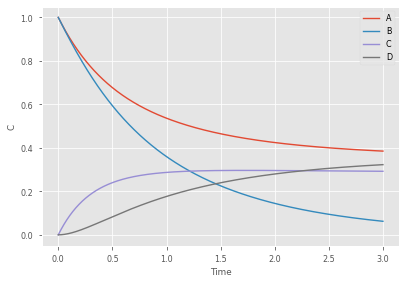

In [23]:
plot_results(t_eval, real_results, labels=['A', 'B', 'C', 'D'])
plt.xlabel('Time')
plt.ylabel('C')


Text(0, 0.5, 'C')

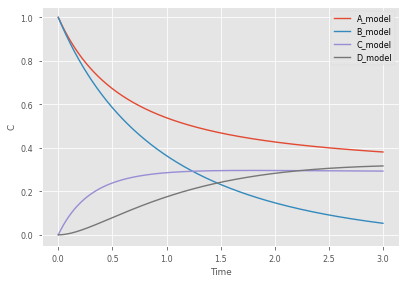

In [24]:
plot_results(t_eval, model_results, labels=['A_model', 'B_model', 'C_model', 'D_model'])
plt.xlabel('Time')
plt.ylabel('C')

In [16]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [17]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

In [18]:
sindy_optm = SR3(threshold=0.1, nu=1, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

In [19]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=10, interaction_only=True),
      feature_names=['x0', 'x1', 'x2', 'x3'],
      optimizer=SR3(max_iter=100, nu=1))

In [20]:
sindy_model.print()

x0' = 6.596 1 + 9.816 x0 + -21.145 x1 + -9.269 x2 + -91.494 x3 + 3.619 x0 x1 + -90.564 x0 x2 + 146.105 x0 x3 + 103.743 x1 x2 + -73.425 x1 x3 + 294.261 x2 x3 + -6.605 x0 x1 x2 + 2.346 x0 x1 x3 + -387.378 x0 x2 x3 + 130.448 x1 x2 x3 + 129.348 x0 x1 x2 x3
x1' = 5.742 1 + 3.676 x0 + -13.054 x1 + -11.170 x2 + -62.750 x3 + 2.447 x0 x1 + -51.922 x0 x2 + 102.912 x0 x3 + 64.870 x1 x2 + -52.383 x1 x3 + 209.217 x2 x3 + -5.373 x0 x1 x2 + 5.623 x0 x1 x3 + -289.903 x0 x2 x3 + 97.927 x1 x2 x3 + 96.121 x0 x1 x2 x3
x2' = -9.040 1 + -13.814 x0 + 26.799 x1 + 13.574 x2 + 128.665 x3 + -2.905 x0 x1 + 121.646 x0 x2 + -207.372 x0 x3 + -139.859 x1 x2 + 104.763 x1 x3 + -417.231 x2 x3 + 10.090 x0 x1 x2 + -0.709 x0 x1 x3 + 566.244 x0 x2 x3 + -189.424 x1 x2 x3 + -188.019 x0 x1 x2 x3
x3' = 321.880 1 + -347.371 x0 + 73.930 x1 + -541.352 x2 + -865.033 x3 + -48.441 x0 x1 + -595.133 x0 x2 + 1251.403 x0 x3 + 1144.421 x1 x2 + -676.690 x1 x3 + 2534.943 x2 x3 + -402.690 x0 x1 x2 + -277.873 x0 x1 x3 + -2479.318 x0 x2 x3 + 8

In [21]:
sindy_model.coefficients()

array([[ 6.59563696e+00,  9.81587742e+00, -2.11448460e+01,
        -9.26890925e+00, -9.14940572e+01,  3.61859035e+00,
        -9.05638274e+01,  1.46105333e+02,  1.03742690e+02,
        -7.34249600e+01,  2.94261258e+02, -6.60458461e+00,
         2.34606180e+00, -3.87378239e+02,  1.30448235e+02,
         1.29347794e+02],
       [ 5.74157899e+00,  3.67647514e+00, -1.30541544e+01,
        -1.11701557e+01, -6.27502777e+01,  2.44713278e+00,
        -5.19217620e+01,  1.02912434e+02,  6.48701146e+01,
        -5.23828089e+01,  2.09216800e+02, -5.37279006e+00,
         5.62303804e+00, -2.89903100e+02,  9.79274151e+01,
         9.61213047e+01],
       [-9.03959472e+00, -1.38143238e+01,  2.67992832e+01,
         1.35739284e+01,  1.28664853e+02, -2.90461546e+00,
         1.21646273e+02, -2.07372206e+02, -1.39858781e+02,
         1.04763233e+02, -4.17231101e+02,  1.00903519e+01,
        -7.08621216e-01,  5.66243894e+02, -1.89423822e+02,
        -1.88019165e+02],
       [ 3.21880079e+02, -3.47370506e

In [22]:
sindy_model.score(model_preds_np, t_eval_np)

0.9999999978156292